In [1]:
import os
import gym
import csv
import math
import enum
import torch
import gym.spaces
import collections
import numpy as np
import torch.nn as nn
import matplotlib as mpl
from gym.utils import seeding
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
retention = 10
EPSILON = 0.02
commission=0.0

In [3]:
from google.colab import drive

drive.mount('/content/drive')

!ls "/content/drive/My Drive/RL_Project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mean_val_-0.017+ENV_B+DuelingDQN.data  mean_val_0.15+ENV_B+DQN.data
mean_val_-0.040+ENV_A+DuelingDQN.data  YNDX_150101_151231.csv
mean_val_0.052+ENV_A+DQN.data	       YNDX_160101_161231.csv


In [4]:
data_path = '/content/drive/My Drive/RL_Project/YNDX_160101_161231.csv'
# data_path = '/content/drive/My Drive/RL_Project/YNDX_150101_151231.csv'
# model = '/content/drive/My Drive/RL_Project/mean_val--0.014.data'
env_a_model_dueling_dqn = '/content/drive/My Drive/RL_Project/mean_val_-0.040+ENV_A+DuelingDQN.data'
env_b_model_dueling_dqn = '/content/drive/My Drive/RL_Project/mean_val_-0.017+ENV_B+DuelingDQN.data'
env_a_model_dqn = '/content/drive/My Drive/RL_Project/mean_val_0.052+ENV_A+DQN.data'
env_b_model_dqn = '/content/drive/My Drive/RL_Project/mean_val_0.15+ENV_B+DQN.data'

## File Reading

In [5]:
data_fields=['open', 'high', 'low', 'close', 'volume']
data_headings=['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']
Records = collections.namedtuple('Records', field_names=data_fields)

In [6]:
def create_records(data):
  for key in data:
    data[key]=np.array(data[key])
  rec_collection = Records(open=data['open'], high=data['high'], low=data['low'], close=data['close'], volume=data['volume'])
  return Records(open=rec_collection.open, 
                 high=(rec_collection.high - rec_collection.open) / rec_collection.open, 
                 low=(rec_collection.low - rec_collection.open) / rec_collection.open, 
                 close=(rec_collection.close - rec_collection.open) / rec_collection.open, 
                 volume=rec_collection.volume)

def read_csv(path):
    print("Dataset File", path)
    with open(path, 'rt', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=',')
        headings = next(reader)

        data = dict()
        for key in data_fields:
          data[key]=[]
        
        for row in reader:
            values = []
            for index, key in zip([headings.index(s) for s in tuple(data_headings)], data):
                data[key].append(float(row[index]))
    return create_records(data)

In [7]:
records = read_csv(data_path)

Dataset File /content/drive/My Drive/RL_Project/YNDX_160101_161231.csv


## Environment Setup

In [8]:
stock_actions = {'Skip':0,'Buy':1,'Close':2}
stock_actions_rev = {}
for key in stock_actions:
    stock_actions_rev[stock_actions[key]]=key

In [9]:
class StockExchangeEnvironmentA(gym.Env):
    
    def __init__(self):
        self._actions = stock_actions
        self._num_actions=len(self._actions)
        self._records=records
        self._shape=(3*retention+2, )
        self._action_space = gym.spaces.Discrete(n=self._num_actions)
        self._observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=self._shape, dtype=np.float32)
        
    def reset(self):
        self.open_price = 0
        self._count=retention
        self._records=records
        self.bought = False
        
        results, _, __ = self.step_results(0, 1, 1)
        
        return results
    
    def step(self, action_type):
        reward = 0
        current_action = self._actions[action_type]
        # if we are holding any stock 
        if self.bought:
            # if current action is to close
            if current_action == stock_actions['Close']:
                reward -= commission
                self.bought = False
                self.open_price = 0.0           
            else:
                # cant do anything in this case
                pass
        # if we are not holding any stock
        else:
            # current action is to buy
            if self._actions[action_type] == stock_actions['Buy']:
                self.bought = True
                self.open_price = self._records.open[self._count] * (self._records.close[self._count] + 1)
                reward -= commission
            else:
                # can't do anything in this case
                pass
        close_initial = self._records.open[self._count] * (self._records.close[self._count] + 1)
        self._count += 1
        close_final = self._records.open[self._count] * (self._records.close[self._count] + 1)

        results, reward, terminated = self.step_results(reward, close_initial, close_final)
        
        return results, reward, terminated
    
    def step_results(self, reward, close_initial, close_final):
        if self.bought:
            reward += ((close_final - close_initial)/close_initial)*100

        terminated = False
        terminated |= self._count >= self._records.close.shape[0]-1
   
        itr=0
        results = np.ndarray(shape=self._shape, dtype=np.float32)
        for record in range(1-retention,1):
            results[itr] = self._records.high[self._count + record]
            results[itr+1] = self._records.high[self._count + record]
            results[itr+2] = self._records.high[self._count + record]
            itr+=3

        results[itr] = float(self.bought)
        if not self.bought:
            results[itr+1] = 0.0
        else:
            results[itr+1] = (self._records.open[self._count] * (self._records.close[self._count] + 1) - self.open_price) / self.open_price    
        
        return results, reward, terminated

In [10]:
class StockExchangeEnvironmentB(gym.Env):
    
    def __init__(self):
        self._actions = stock_actions
        self._num_actions=len(self._actions)
        self._records=records
        self._shape=(3*retention+2, )
        self._action_space = gym.spaces.Discrete(n=self._num_actions)
        self._observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=self._shape, dtype=np.float32)
        
    def reset(self):
        self.open_price = 0
        self._count=retention
        self._records=records
        self.bought = False
        
        results, _, __ = self.step_results(0, 1, 1)
        
        return results
    
    def step(self, action_type):
        reward = 0
        current_action = self._actions[action_type]
        # if we are holding any stock 
        if self.bought:
            # if current action is to close
            if current_action == stock_actions['Close']:
                reward -= commission
                self.bought = False
                self.open_price = 0.0           
            else:
                # cant do anything in this case
                pass
        # if we are not holding any stock
        else:
            # current action is to buy
            if self._actions[action_type] == stock_actions['Buy']:
                self.bought = True
                self.open_price = self._records.open[self._count] * (self._records.close[self._count] + 1)
                reward -= commission
            else:
                # can't do anything in this case
                pass
        close_initial = self._records.open[self._count] * (self._records.close[self._count] + 1)
        self._count += 1
        close_final = self._records.open[self._count] * (self._records.close[self._count] + 1)

        results, reward, terminated = self.step_results(reward, close_initial, close_final)
        
        return results, reward, terminated
    
    def step_results(self, reward, close_initial, close_final):
        if self.bought:
            reward += (close_final - close_initial)

        terminated = False
        terminated |= self._count >= self._records.close.shape[0]-1
   
        itr=0
        results = np.ndarray(shape=self._shape, dtype=np.float32)
        for record in range(1-retention,1):
            results[itr] = self._records.high[self._count + record]
            results[itr+1] = self._records.high[self._count + record]
            results[itr+2] = self._records.high[self._count + record]
            itr+=3

        results[itr] = float(self.bought)
        if not self.bought:
            results[itr+1] = 0.0
        else:
            results[itr+1] = (self._records.open[self._count] * (self._records.close[self._count] + 1) - self.open_price)  
        
        return results, reward, terminated

In [11]:
env = StockExchangeEnvironmentA()

## DQN Models

In [12]:
class DQN(nn.Module):
    def __init__(self, observations, actions):
        super(DQN, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(observations.shape[0], 512),
            nn.ReLU(),
            nn.Linear(512, actions.n)
        )

    def forward(self, x):
        return self.fc(x)


class DuelingDQN(nn.Module):
    def __init__(self, observations, actions):
        super(DuelingDQN, self).__init__()

        self.fc_val = nn.Sequential(
            nn.Linear(observations.shape[0], 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        self.fc_adv = nn.Sequential(
            nn.Linear(observations.shape[0], 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, actions.n)
        )

    def forward(self, x):
        val = self.fc_val(x)
        adv = self.fc_adv(x)
        return val + adv - adv.mean(dim=1, keepdim=True)

In [13]:
net = DQN(env._observation_space, env._action_space)

## Evaluation

In [14]:
def plot_rewards(rewards, tag=''):
  fig, ax = plt.subplots(figsize=(12,6))

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)

  ax.plot(rewards)

  ax.set_xlabel('Time (minutes)', labelpad=20, color='#333333', size=15)
  ax.set_ylabel('Reward percentage', labelpad=25, color='#333333', size=15)
  ax.set_title('Total reward vs Time Stamps: '+tag, pad=30, color='#333333', weight='bold', size=20)
  plt.show()

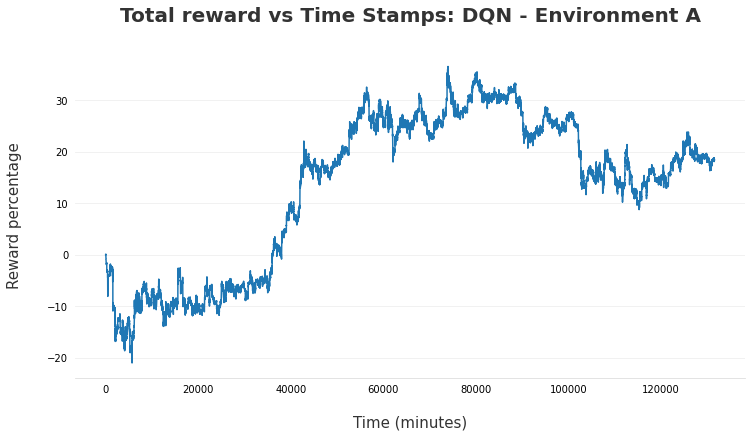

In [15]:
def stock_prediction(net, env, model, remarks=''):
  net.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage))
  observation = env.reset()
  start_price = env._records.open[retention] * (env._records.close[retention] + 1)

  itr = 0
  total_reward = 0.0
  reward_warehouse = []

  terminated=False
  while not terminated:
      itr += 1
      observation_tensor = torch.tensor([observation])
      values = net(observation_tensor)
      action_code = values.max(dim=1)[1].item()
      if np.random.random() < EPSILON:
          action_code = env._action_space.sample()
      obs, reward, terminated = env.step(stock_actions_rev[action_code])
      total_reward += reward
      reward_warehouse.append(total_reward)
  plot_rewards(reward_warehouse, remarks)

stock_prediction(net, env, env_a_model_dqn, 'DQN - Environment A')

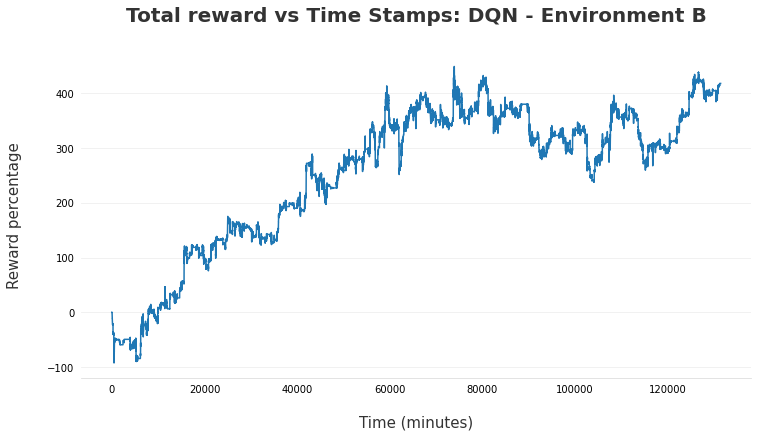

In [16]:
env = StockExchangeEnvironmentB()
net = DQN(env._observation_space, env._action_space)
stock_prediction(net, env, env_b_model_dqn,'DQN - Environment B')

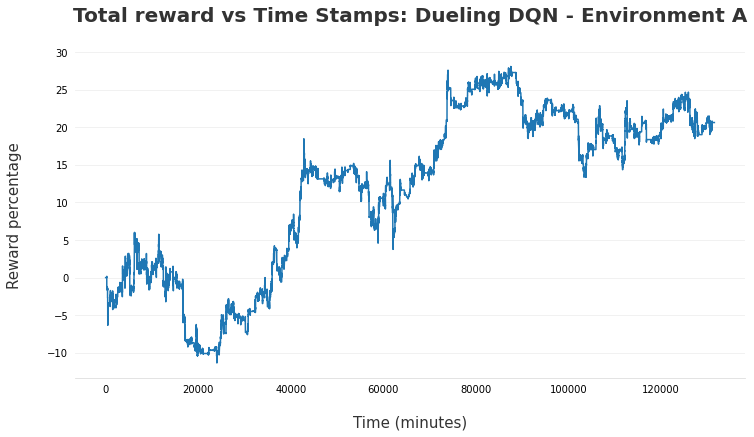

In [17]:
env = StockExchangeEnvironmentA()
net = DuelingDQN(env._observation_space, env._action_space)
stock_prediction(net, env, env_a_model_dueling_dqn,'Dueling DQN - Environment A')

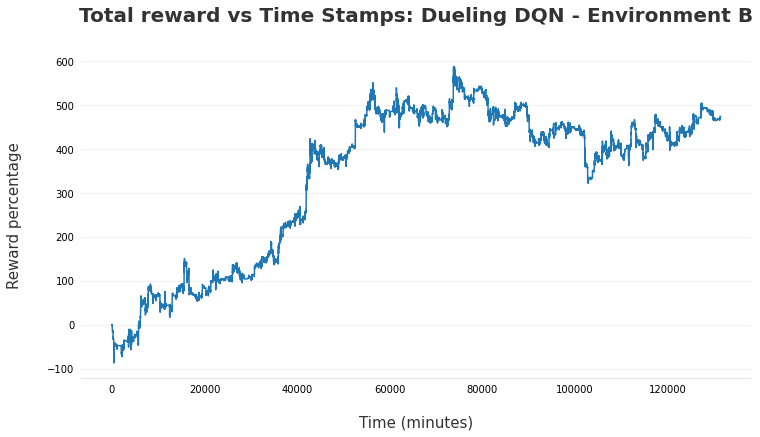

In [19]:
env = StockExchangeEnvironmentB()
net = DuelingDQN(env._observation_space, env._action_space)
stock_prediction(net, env, env_a_model_dueling_dqn, 'Dueling DQN - Environment B')